# Fitting dispersive material models

Here we show how to fit optical measurement data and use the results to create dispersion material models for `Tidy3D`.

`Tidy3D`'s dispersion fitting tool peforms an optimization to find a medium defined as a dispersive [PoleResidue](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PoleResidue.html) model that minimizes the RMS error between the model results and the data. This can then be directly used as a material in simulations.

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. For simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

We recommend using the [FastDispersionFitter](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html), with advanced options configurable using the [AdvancedFastFitterParam](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.AdvancedFastFitterParam.html). As a backup, we also offer another fitter that uses global optimization and is based on a webservice. See below for the usage details of this dispersion fitter webservice.

In [1]:
# first import packages
import matplotlib.pylab as plt
import numpy as np

import tidy3d as td

## Load Data

The fitting tool accepts three ways of loading data:

1. Numpy arrays directly by specifying `wvl_um`, `n_data`, and optionally `k_data`;

2. Data file with the `from_file` utility function.

    Our data file has columns for wavelength (um), real part of refractive index (n), and imaginary part of refractive index (k).  k data is optional. 
    
    Note: `from_file` uses [np.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) under the hood, so additional keyword arguments for parsing the file follow the same format as [np.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html).
    
3. URL linked to a csv/txt file that contains wavelength (micron), n, and optionally k data with the `from_url` utility function. URL can come from [refractiveindex.info](https://refractiveindex.info).

Below the 2nd way is taken as an example:

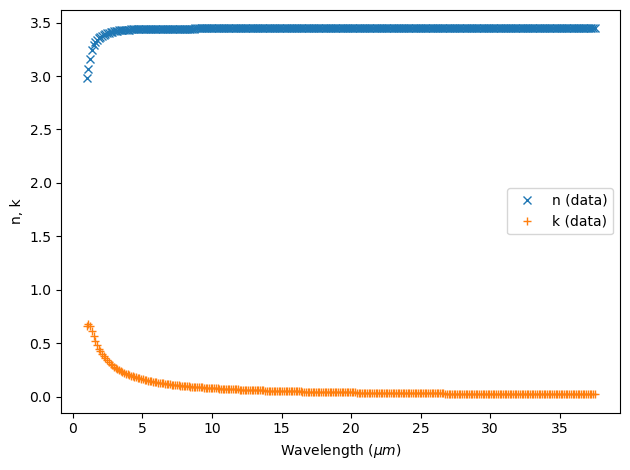

In [2]:
from tidy3d.plugins.dispersion import FastDispersionFitter, AdvancedFastFitterParam

fname = "misc/nk_data.csv"

# note that additional keyword arguments to load_nk_file get passed to np.loadtxt
fitter = FastDispersionFitter.from_file(fname, skiprows=1, delimiter=",")

# lets plot the data
fitter.plot()
plt.show()


## Fitting the data

The fitting tool fit a dispersion model to the data by minimizing the root mean squared (RMS) error between the model n,k prediciton and the data at the given wavelengths.

There are various fitting parameters that can be set, but the most important is the number of "poles" in the model.

For each pole, there are 4 degrees of freedom in the model.  Adding more poles can produce a closer fit, but each additional pole added will make the fit harder to obtain and will slow down the FDTD.  Therefore, it is best to try the fit with few numbers of poles and increase until the results look good.

Here, we will first try fitting the data with 1 pole and specify the RMS value that we are happy with (`tolerance_rms`).

We specify weights for the real and imaginary part of the permittivity using `AdvancedFastFitterParam`, although the default weights which are calculated based on the typical values would also work fine here. Also note that, by default, `eps_inf` is optimized, although alternatively a fixed value for `eps_inf` can be specified as an argument to `fitter.fit`.

Output()

12:47:57 Eastern Standard Time WARNING: Unable to fit with weighted RMS error   
                               under 'tolerance_rms' of 0.02                    

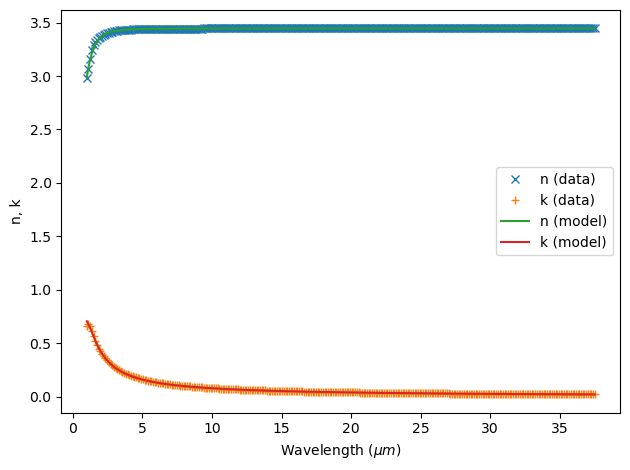

In [3]:
advanced_param = AdvancedFastFitterParam(weights=(1,1))
medium, rms_error = fitter.fit(max_num_poles=1, advanced_param=advanced_param, tolerance_rms=2e-2)
fitter.plot(medium)
plt.show()


The RMS error was above our tolerance and there is room for improvement at short wavelengths, so we might want to try more fits.

Let's now try a fit with up to 3 poles.

Output()

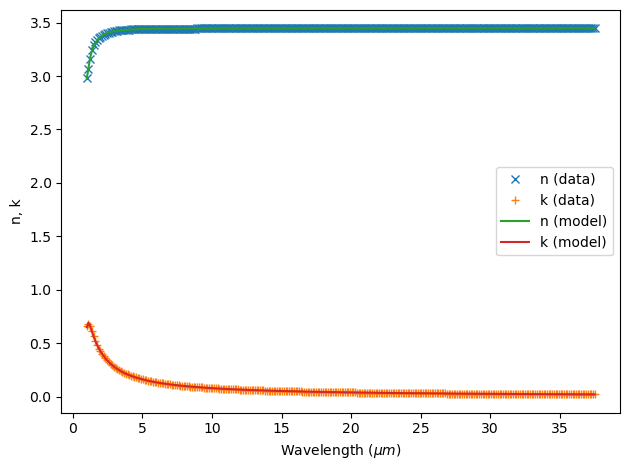

In [4]:
medium, rms_error = fitter.fit(max_num_poles=3, advanced_param=advanced_param, tolerance_rms=2e-2)
fitter.plot(medium)
plt.show()


This fit looks great and should be sufficient for our simulation.

Alternatively, if the simulation is narrowband, you might want to truncate your data to not include wavelengths far outside your measurement wavelength to simplify the dispersive model. This is through modifying the attribute `wvl_range` where you can set the lower wavelength bound `wvl_range[0]` and the higher wavelength bound `wvl_range[1]`. This operation is non-destructive, so you can always unset them by setting the value to `None`. 

E.g. if we are only interested in the wavelength 3-20 um, we can still use the single-pole model:

In [5]:
fitter = fitter.copy(update={"wvl_range": (3, 20)})
medium, rms_error = fitter.fit(max_num_poles=1, tolerance_rms=2e-2)


Output()

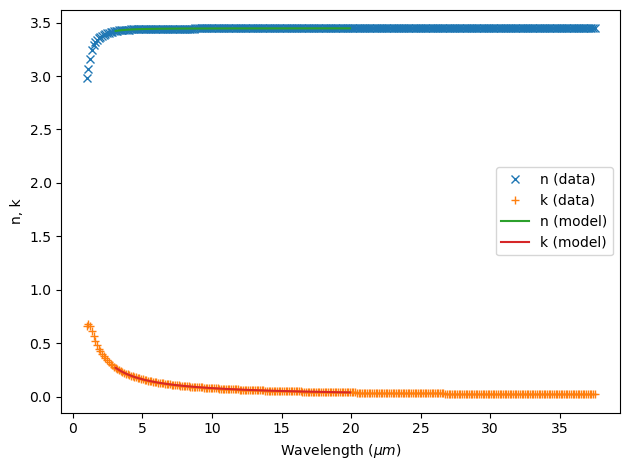

In [6]:
fitter.plot(medium)
plt.show()


## Using Fit Results

With the fit performed, we want to use the `Medium` in our simulation.


### Method 1: direct export as Medium

The fit returns a medium, which can be used directly in simulation

In [7]:
b = td.Structure(geometry=td.Box(size=(1, 1, 1)), medium=medium)


### Method 2: print medium definition string

In many cases, one may want to perform the fit once and then hardcode the result in their tidy3d script.

For a quick and easy way to do this, just `print()` the medium and the output can be copied and pasted into your main svript

In [8]:
print(medium)


td.PoleResidue(
	eps_inf=3.3946193815572663, 
	poles=(((-1667817350156709.8-206849778477666.2j), (1.0047082751084586e+16-2.307684527442218e+16j)),), 
	frequency_range=None)


In [9]:
# medium = td.PoleResidue(
# 	eps_inf=3.394619381557077, 
# 	poles=(((-1667817350156741.8-206849778477574.28j), (1.004708275108508e+16-2.307684527443524e+16j)),), 
# 	frequency_range=None)

### Method 3: save and load file containing poles

Finally, one can save export the `Medium` directly as .json file. Here is an example.

In [10]:
# save poles to pole_data.txt
fname = "misc/my_medium.json"
medium.to_file(fname)

# load the file in your script
medium = td.PoleResidue.from_file(fname)


## Advanced Parameters and Tips for FastDispersionFitter

There are a number of advanced parameters for the `FastDispersionFitter` which can be useful if the default settings do not work to find a fit. The advanced parameters are configured by passing in an `AdvancedFastFitterParam` object. When trying to improve a fit, the first thing to try is changing the arguments `max_num_poles` and `eps_inf` to the `fit` function. Importantly, although `eps_inf = None` performs optimization for the value of `eps_inf` as well, this optimization is nontrivial and so it can sometimes be better to provide a fixed value of `eps_inf`. Besides these arguments, the following advanced parameters may be helpful:

- `loss_bounds = (lower, upper)` are bounds on `Im[eps]` over all frequencies (not just the fitting range). The default `(0, np.inf)` corresponds to a passive medium requirement, which leads to stable simulations. The upper bound can be used to ensure a good fit for a lossless medium. Setting a small negative lower bound can sometimes be informative; if a lower bound of 0 results in a poor fit but a small negative lower bound results in a good fit, then the poor fit was due to difficulty satisfying the passivity requirement. A negative lower bound, and thus a violation of the passivity requirement, may result in unstable simulations. However, a small violation of the passivity requirement may on occasion be acceptable, if there is loss elsewhere in the simulation to offset the resulting gain.

- `weights = (real, imag)` are weights for `Re[eps]` and `Im[eps]` used in the fitting objective function (and when reporting rms error). These can be used if it is necessary to more accurately fit either the real or imaginary part.

- `relaxed`, `smooth`, and `logspacing` can usually be left at their default values of `None`, which makes the fitter try both `True` and `False` values and take the better fit. Sometimes, however, it may be clear that specific values are better for a certain medium. `relaxed` controls whether the relaxed version of the fitting algorithm is used. For example, `relaxed = True` could prevent overfitting and also allow for pole relocation further outside the fitting window. The `smooth` and `logspacing` parameters control the initial pole placement. `smooth = True` may be appropriate for fitting metals. `logspacing = True` may be better when the poles are spread over a large frequency range. Again, the default option is usually fine here unless a particular type of model is required, since the default option tries both `True` and `False`.

- `num_iters` controls the tradeoff between speed and quality of fit, although a higher `num_iters` doesn't necessarily result in a better fit. Usually, after a certain number of iterations, the algorithm has converged to a certain fit, and increasing `num_iters` further won't significantly help. However, it may be good to try increasing it to `100` or so to make sure that the algorithm has converged.

Information on additional advanced parameters may be found in the documentation [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.AdvancedFastFitterParam.html).

Here are a couple more general tips on dispersion fitting:

- If you are unable to find a good fit to your data, it might be worth considering whether you care about certain features in the data.  For example as shown above, if the simulation is narrowband, you might want to truncate your data to not include wavelengths far outside your measurement wavelength to simplify the dispersive model.

- It is common to find divergence in FDTD simulations due to dispersive materials. The `FastDispersionFitter` by default should enforce a passivity requirement and produce stable material fits. If there is still a divergence, besides trying "absorber" PML types and reducing runtime, a good solution can be to try other fits; for example, using a smaller number of poles, or setting `loss_bounds = (min_loss, np.inf)` for some small positive number `min_loss` (the latter can only work if the data satisfies this minimum loss constraint).

## Dispersion Fitter Webservice

We also have a dispersion fitter webservice which uses global optimization algorithms to find stable dispersion fits. This webservice may work if the `FastDispersionFitter` does not find an adequate fit. Note however that the `FastDispersionFitter` also produces stable material fits. The dispersion fitter webservice is run on Flexcompute servers, so this tool reqiures signing in to a `Tidy3D` account. 

The dispersion fitter webservice is setup using the [DispersionFitter](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.DispersionFitter.html) and [AdvancedFitterParam](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.AdvancedFitterParam.html) classes, and run using [dispersion.web.run](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.web.run.html) to obtain stable material fits. This interface replaces the deprecated `StableDispersionFitter` class. We use `dispersion.web.run` instead of `DispersionFitter.fit`; the latter runs locally but may produce unstable material fits, so is not recommended.

Here is a demonstration of the dispersion fitter webservice.

In [11]:
from tidy3d.plugins.dispersion import DispersionFitter, AdvancedFitterParam
from tidy3d.plugins.dispersion.web import run as run_fitter

fname = "misc/nk_data.csv"
fitter_stable = DispersionFitter.from_file(fname, skiprows=1, delimiter=",")


In [12]:
medium, rms_error = run_fitter(
    fitter_stable,
    num_poles=2,
    tolerance_rms=2e-2,
    num_tries=50,
    advanced_param=AdvancedFitterParam(nlopt_maxeval=10000),
)


Note here we supply the `advanced_param` for more control of the fitting process. `nlopt_maxeval` stands for the maximal number of iterations for each inner optimization. Details of a list of other advanced parameters will be explained later.

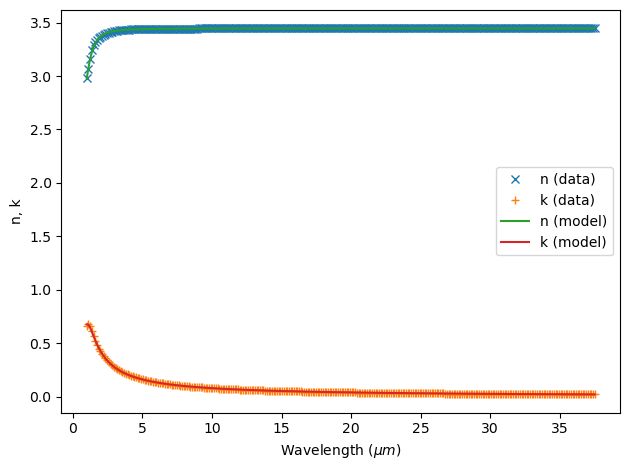

In [13]:
fitter_stable.plot(medium)
plt.show()


Once the fitting is performed, the procedure of using the medium in our simulation is also idential to the previous fitting tool, which we will not go into details here.

## Tricks and Tips / Troubleshooting for StableDispersionFitter

Performing dispersion model fits is more of an art than a science and some trial and error may be required to get good fits.  A good general strategy is to:

- Start with few poles and increase until RMS error gets to the desired level.

- Large `num_tries` values can sometimes find good fits if the RMS seems stalled. It can be a good idea to set a large number of tries and let it run for a while on an especially difficult data model. However, our stable fitter is based on a web service, and therefore it can run into `timeout` errors if the fitter runs for too long. In this case, you are encouraged to decrease the value of `num_tries` or to relax the value of `tolerance_rms` to your needs.

- Tailor the parameters to your data.  Long wavelengths and large n,k values can affect the RMS error that is considered a 'good' fit.  So it is a good idea to tweak the tolerance to match your data.  Once size does not fit all.

- Our stable fitting tool performs global optimizations with random starting coefficients, and will repeat the optimization `num_tries` times. Within each inner optimization, the maximal number of iterations is bounded by an  **advanced parameter** `nlopt_maxeval` whose default value is `5000`. Since there is a well-known tradeoff between exploration and exploitation in a typical global optimization process, you can play around with `num_tries` and `nlopt_maxeval`. In particular in senarios where `timeout` error occurs and decreasing `num_tries` leads to larger RMS error, you can try to decrease `nlopt_maxeval`.

A list of other advanced parameters can be found in our documentation. For example:

- In cases where the permittivity at infinity frequency is other than 1, it can also be optimized by setting an **advanced parameter** `bound_eps_inf` so that the permittivity at infinite frequency can take values between `[1,bound_eps_inf]`.

- Sometimes we want to bound the pole frequency in the dispersive model. The lower and upper bound can be set with `bound_f_lower` and `bound_f`, respectively.

- The stable fitting tool performs global optimizations with random starting coefficients. By default, the value of the seed `rand_seed=0` is fixed, so that you'll obtain identical results when re-running the fitter. If you want to re-run the fitter several times to obtain the best results, the value of the seed should be changed, or set to  `None` so that the starting coefficients are different each time. 